<a href="https://colab.research.google.com/github/AkiraMJ/-MEC-502_Topicos_MecSol-/blob/main/Atividade3_3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Placa Estática 2D Exercício 3b

*
Implemente em PyTorch uma PINN para encontrar os deslocamentos nas direções x e y para o problema da placa bidimensional.

*Engaste no lado esquerdo e apoio no lado inferior.

* σxx(L, y) = sin (πy/L)e σxy = 0 em todo o contorno.



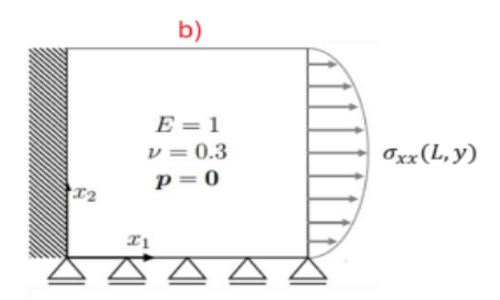

In [ ]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1NvAfS7iU3LTqyi8VYwcCe8JvsSF5MEJs'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (500, 300)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)
#https://drive.google.com/file/d/1NvAfS7iU3LTqyi8VYwcCe8JvsSF5MEJs/view?usp=drive_link

Epoch: 0/5000	DE cost = 3.01e-04	BC cost = 6.03e-01	Total cost = 6.03e-01	Elapsed time = 0.001766
Epoch: 500/5000	DE cost = 9.33e-03	BC cost = 6.97e-02	Total cost = 7.90e-02	Elapsed time = 0.896768
Epoch: 1000/5000	DE cost = 3.54e-03	BC cost = 9.26e-03	Total cost = 1.28e-02	Elapsed time = 0.834906
Epoch: 1500/5000	DE cost = 1.99e-03	BC cost = 5.61e-03	Total cost = 7.60e-03	Elapsed time = 0.856334
Epoch: 2000/5000	DE cost = 1.28e-03	BC cost = 4.11e-03	Total cost = 5.39e-03	Elapsed time = 0.846829
Epoch: 2500/5000	DE cost = 1.04e-03	BC cost = 3.46e-03	Total cost = 4.50e-03	Elapsed time = 0.847370
Epoch: 3000/5000	DE cost = 8.34e-04	BC cost = 3.16e-03	Total cost = 3.99e-03	Elapsed time = 0.848100
Epoch: 3500/5000	DE cost = 6.42e-04	BC cost = 2.94e-03	Total cost = 3.58e-03	Elapsed time = 0.816461
Epoch: 4000/5000	DE cost = 5.83e-04	BC cost = 2.76e-03	Total cost = 3.35e-03	Elapsed time = 0.804016
Epoch: 4500/5000	DE cost = 4.62e-04	BC cost = 2.49e-03	Total cost = 2.96e-03	Elapsed time = 0.8

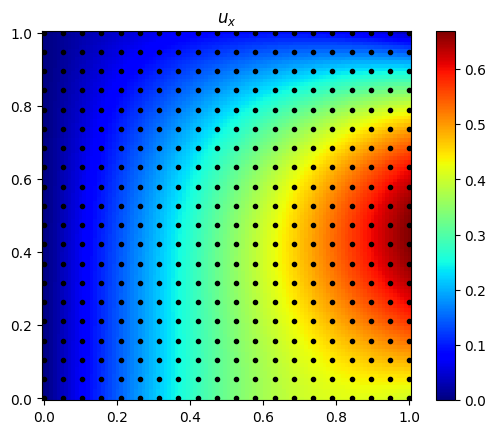

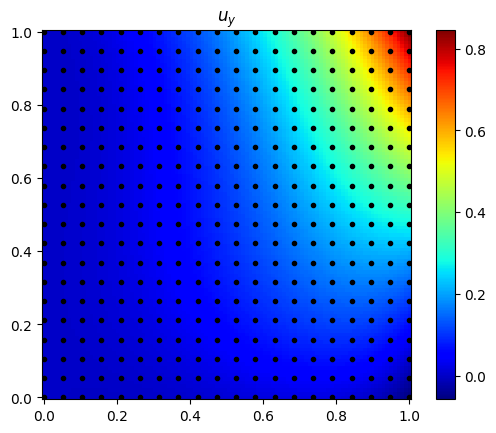

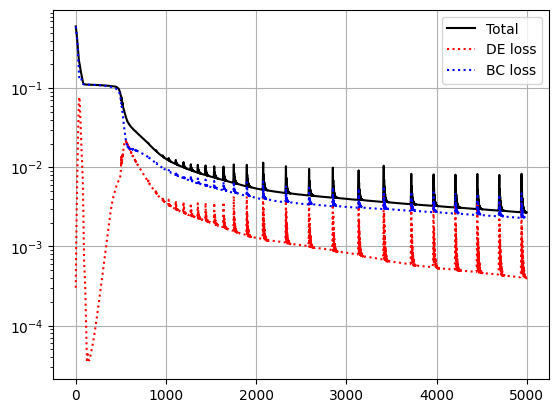

In [ ]:
import numpy as np
import torch
from torch.autograd import grad
import time
import matplotlib.pyplot as plt

def getDerivative(y, x, n):
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones_like(x), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

class NN(torch.nn.Module):
    def __init__(self, inputDimension, hiddenDimensions, outputDimension, activationFunction=torch.nn.Tanh()):
        super().__init__()
        layers = []
        layers.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        layers.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            layers.append(torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1]))
            layers.append(activationFunction)
        layers.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def getGrid(Lx, Ly, Nx, Ny):
    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    x, y = torch.meshgrid(x, y, indexing="ij")
    x.requires_grad = True
    y.requires_grad = True
    input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
    return x, y, input

# --- Boundary enforcement ---
# Hard: engaste (x=0) -> ux=0, uy=0
def strongEnforcement_ux(u_x, x, Lx):
    return (x / Lx) * u_x

def strongEnforcement_uy(u_y, x, Lx):
    return (x / Lx) * u_y

# Dados do problema
Lx = 1.0
Ly = 1.0
E = 1.0
nu = 0.3

C = torch.zeros((3, 3))
C[0, 0] = 1
C[0, 1] = nu
C[1, 0] = nu
C[1, 1] = 1
C[2, 2] = 1 - nu
C *= E / (1 - nu**2)

def getDisplacements(model, input, Lx):
    u = model(input)
    x = input[:, 0]
    ux = strongEnforcement_ux(u[:, 0], x, Lx).unsqueeze(1)
    uy = strongEnforcement_uy(u[:, 1], x, Lx).unsqueeze(1)
    return torch.cat((ux, uy), 1)

def getStrains(u, x, y, Nx, Ny):
    ux_grid = u[:, 0].reshape(Nx, Ny)
    uy_grid = u[:, 1].reshape(Nx, Ny)
    eps_xx = getDerivative(ux_grid, x, 1)
    eps_yy = getDerivative(uy_grid, y, 1)
    eps_xy = 0.5 * (getDerivative(ux_grid, y, 1) + getDerivative(uy_grid, x, 1))
    strain = torch.zeros((3, Nx, Ny), dtype=eps_xx.dtype, device=eps_xx.device)
    strain[0] = eps_xx
    strain[1] = eps_yy
    strain[2] = eps_xy
    return strain

def getLossTerms(x, y, u, Nx, Ny, C, Lx, Ly):
    strain = getStrains(u, x, y, Nx, Ny)
    stress = torch.tensordot(C, strain, dims=1)

    # Equilíbrio PDE
    dsig11_dx = getDerivative(stress[0], x, 1)
    dsig12_dy = getDerivative(stress[2], y, 1)
    dsig21_dx = getDerivative(stress[2], x, 1)
    dsig22_dy = getDerivative(stress[1], y, 1)

    EDP_Loss = torch.mean((dsig11_dx + dsig12_dy) ** 2) + torch.mean((dsig21_dx + dsig22_dy) ** 2)

    # Soft BC Loss
    BC_Loss = 0.0
    # Tração na direita: sigma_xx(Lx,y) = sin(pi*y/Ly)
    traction = torch.sin(np.pi * y[0, :] / Ly).to(stress)
    BC_Loss += torch.mean((stress[0][-1, :] - traction) ** 2)

    # sigma_xy = 0 em todo o contorno
    BC_Loss += torch.mean(stress[2][0, :] ** 2)      # esquerda
    BC_Loss += torch.mean(stress[2][-1, :] ** 2)     # direita
    BC_Loss += torch.mean(stress[2][:, 0] ** 2)      # inferior
    BC_Loss += torch.mean(stress[2][:, -1] ** 2)     # superior

    # Soft rolete: uy=0 em y=0
    BC_Loss += torch.mean(u[:, 1].reshape(Nx, Ny)[:, 0] ** 2)

    return EDP_Loss, BC_Loss

# Treinamento
Nx = 20
Ny = 20
hiddenDimensions = [20, 20, 20, 20]
activationFunction = torch.nn.SiLU()
epochs = 5000
lr = 1e-3
weightLrFactor = 1e1

model = NN(2, hiddenDimensions, 2, activationFunction)
optimizer = torch.optim.Adam(model.parameters(), lr)
weights = torch.ones(2, requires_grad=True)
optimizer.add_param_group({"params": weights})
optimizer.param_groups[-1]["lr"] = lr * weightLrFactor

x, y, input = getGrid(Lx, Ly, Nx, Ny)
EDP_LossHistory = np.zeros(epochs)
BC_LossHistory = np.zeros(epochs)
costHistory = np.zeros(epochs)
start = time.perf_counter()

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     uPred = getDisplacements(model, input, Lx)
#     lossTerms = getLossTerms(x, y, uPred, Nx, Ny, C, Lx, Ly)
#     cost = weights[0] * lossTerms[0] + weights[1] * lossTerms[1]
#     cost.backward()
#     with torch.no_grad():
#         weights.grad *= -1
#     optimizer.step()

#     EDP_LossHistory[epoch] = lossTerms[0].item()
#     BC_LossHistory[epoch] = lossTerms[1].item()
#     costHistory[epoch] = lossTerms[0].item() + lossTerms[1].item()

#     if epoch % 50 == 0:
#         print(f"Epoch {epoch}/{epochs}  DE: {EDP_LossHistory[epoch]:.2e}  BC: {BC_LossHistory[epoch]:.2e}")
for epoch in range(epochs):
    optimizer.zero_grad()
    uPred = getDisplacements(model, input, Lx)
    lossTerms = getLossTerms(x, y, uPred, Nx, Ny, C, Lx, Ly)
    cost = weights[0] * lossTerms[0] + weights[1] * lossTerms[1]
    cost.backward()
    weights.grad *= -1
    optimizer.step()

    EDP_LossHistory[epoch] = lossTerms[0].detach()
    BC_LossHistory[epoch] = lossTerms[1].detach()
    costHistory[epoch] = lossTerms[0].detach() + lossTerms[1].detach()

    if epoch % 500 == 0:
        elapsedTime = (time.perf_counter() - start) / 50
        print(f"Epoch: {epoch}/{epochs}\tDE cost = {EDP_LossHistory[epoch]:.2e}\tBC cost = {BC_LossHistory[epoch]:.2e}\tTotal cost = {costHistory[epoch]:.2e}\tElapsed time = {elapsedTime:2f}")
        start = time.perf_counter()

# Pós-processamento
Nx_ = 100
Ny_ = 100
x_, y_, input_ = getGrid(Lx, Ly, Nx_, Ny_)
upred = getDisplacements(model, input_, Lx)

xx = x_.detach()
yy = y_.detach()
u_x = upred[:, 0].reshape(Nx_, Ny_).detach()
u_y = upred[:, 1].reshape(Nx_, Ny_).detach()

fig, ax = plt.subplots()
cp = ax.pcolormesh(xx, yy, u_x, cmap=plt.cm.jet, shading='auto')
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$u_x$")
plt.show()

fig, ax = plt.subplots()
cp = ax.pcolormesh(xx, yy, u_y, cmap=plt.cm.jet, shading='auto')
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$u_y$")
plt.show()

fig, ax = plt.subplots()
ax.plot(costHistory, "k", label="Total")
ax.plot(EDP_LossHistory, "r:", label="DE loss")
ax.plot(BC_LossHistory, "b:", label="BC loss")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()

* A estrutura da rede utilizada (número de camadas e neurônios);

* Quantidade de pontos de colocação - 100 (10x10)
* Função de ativação -SiLU
* Otimizador - Adam
* número de épocas - 5000
* taxa de aprendizagem - lr=0.001

* Destaque como as condições de deslocamentos foram definidas (soft ou hard)

-Condições de Deslocamento (Hard): Impostas por *strongEnforcement* que modifica a saída da rede. Isso garante que os deslocamentos são zero em x=0 e y=0 por construção.

-Condições de Tração (Soft): Adicionadas como um termo de penalidade na função de custo (BC_Loss), que a rede neural tenta minimizar durante o treinamento, mas sem garantia de que serão satisfeitas exatamente.

* Um gráfico para cada um dos deslocamentos (direções x e y) encontrados pela PINN;
* Um gráfico dos valores da função de perda (pode ser somente a Loss Total) pelo número de épocas.